# Tester notebook for RCC

In [48]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping

#from clustering import *
from radially_constrained_cluster import *

/home/jgrassi/miniconda3/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


<Axes: >

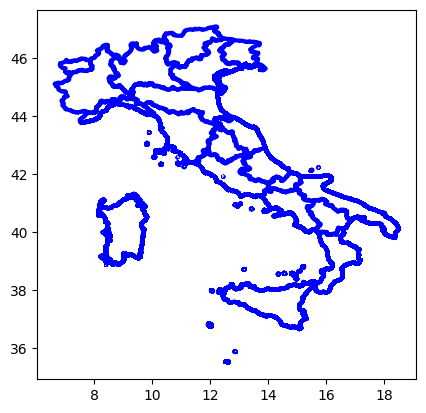

In [49]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp', crs="epsg:4326")
italy_region.boundary.plot(color = 'b', linewidth = 3, label = 'Regioni')


# abruzzo 1
# puglia 2
# basilicata 3
# calabria 4
# campania 5
# emiliaromagna 6
# friulivg 7
# lazio = 8
# liguria 9 
# lombardia 10
# marche 11
# molise 12
# piemonte 13
# sardegna 14
# sicilia 15
# toscana 16
# trentinoag 17
# umbria 18
# aosta 19
# veneto 20

In [50]:
data_path = '/work/users/jgrassi/data/ERA5'
dataset_t2m_ori = xr.open_mfdataset(rf'{data_path}/2m_temperature/*.nc')
dataset_t2m_ori = dataset_t2m_ori.convert_calendar('noleap').rolling(time=10*24, center=True).mean()

dataset_tp_ori = xr.open_mfdataset(rf'{data_path}/total_precipitation/*.nc')
dataset_tp_ori = dataset_tp_ori.convert_calendar('noleap').rolling(time=10*24, center=True).mean()

dataset_ws_ori = xr.open_mfdataset(rf'{data_path}/10m_wind_speed/*.nc')
dataset_ws_ori = dataset_ws_ori.convert_calendar('noleap').rolling(time=10*24, center=True).mean()


gpp = italy_region.loc[13]
new = gpd.GeoDataFrame(gpp)
new.columns = ['geometry']
gdf = new.set_geometry('geometry')

In [51]:
dataset_t2m_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
dataset_t2m_ori.rio.write_crs("epsg:4326", inplace=True)

dataset_tp_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
dataset_tp_ori.rio.write_crs("epsg:4326", inplace=True)

dataset_ws_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
dataset_ws_ori.rio.write_crs("epsg:4326", inplace=True)

dataset_t2m_ori = dataset_t2m_ori.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
dataset_tp_ori = dataset_tp_ori.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
dataset_ws_ori = dataset_ws_ori.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

In [52]:
dataset_t2m = dataset_t2m_ori.load()
dataset_t2m = dataset_t2m.groupby('time.dayofyear').mean().t2m - 273.15

In [53]:
dataset_tp = dataset_tp_ori.load()
dataset_tp = dataset_tp.groupby('time.dayofyear').mean().tp * 1000 * 24

In [54]:
dataset_ws = dataset_ws_ori.load()
dataset_ws = dataset_ws.groupby('time.dayofyear').mean().sfcWind

Text(0, 0.5, 'm/s')

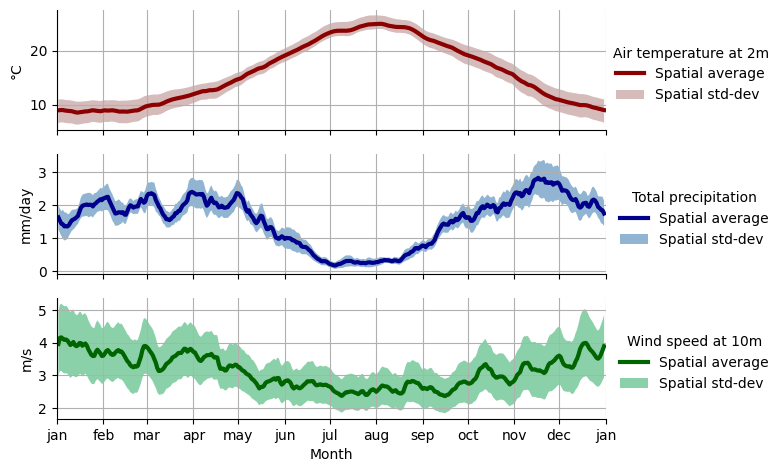

In [87]:
fig, axs = plt.subplots(3,1, figsize=(3.54*2,3.54*1.5), sharex = True, gridspec_kw = {'wspace':0.5,'hspace':0.2}) 

dataset_t2m.mean(['latitude', 'longitude']).plot(ax = axs[0], lw = 3, color='darkred', label='Spatial average')
axs[0].fill_between(dataset_t2m.dayofyear, dataset_t2m.quantile(0.1, ['latitude', 'longitude']), 
                    dataset_t2m.quantile(0.9, ['latitude', 'longitude']), alpha=0.6, facecolor='rosybrown', label='Spatial std-dev')


dataset_tp.mean(['latitude', 'longitude']).plot(ax = axs[1], lw = 3, color = 'darkblue', label='Spatial average')
axs[1].fill_between(dataset_tp.dayofyear, dataset_tp.mean(['latitude', 'longitude']) - dataset_tp.std(['latitude', 'longitude']), 
                    dataset_tp.mean(['latitude', 'longitude']) + dataset_tp.std(['latitude', 'longitude']), alpha=0.6, facecolor='steelblue', label='Spatial std-dev')

dataset_ws.mean(['latitude', 'longitude']).plot(ax = axs[2], lw = 3, color = 'darkgreen', label='Spatial average')
axs[2].fill_between(dataset_ws.dayofyear, dataset_ws.mean(['latitude', 'longitude']) - dataset_ws.std(['latitude', 'longitude']), 
                    dataset_ws.mean(['latitude', 'longitude']) + dataset_ws.std(['latitude', 'longitude']), alpha=0.6, facecolor='mediumseagreen', label='Spatial std-dev')

for ax, title in zip(axs.ravel(), ['Air temperature at 2m', 'Total precipitation', 'Wind speed at 10m']):
    ax.grid()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0,365)
    ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
    ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(1.32, 0.8), title=title, fancybox=True, frameon=False)
    ax.set_title('')


axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('Month')

axs[0].set_ylabel('°C')
axs[1].set_ylabel('mm/day')
axs[2].set_ylabel('m/s')

#fig.suptitle('Surface air temperature and total precipitation seasonal cycles')

In [64]:
array_t2m = dataset_t2m.to_numpy()
array_t2m = np.reshape(array_t2m, (array_t2m.shape[0], array_t2m.shape[1]*array_t2m.shape[2]))

In [65]:
array_tp = dataset_tp.to_numpy()
array_tp = np.reshape(array_tp, (array_tp.shape[0], array_tp.shape[1]*array_tp.shape[2]))

In [66]:
array_ws = dataset_ws.to_numpy()
array_ws = np.reshape(array_ws, (array_ws.shape[0], array_ws.shape[1]*array_ws.shape[2]))

In [67]:
# concatenate the two arrays on columns
array_tot = np.concatenate((array_t2m, array_tp, array_ws), axis=1)

array_tot = array_tot[:,~np.all(np.isnan(array_tot), axis=0)]

In [68]:
# min-max normalization on axis 1
array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)


Text(0, 0.5, 'Within-Cluster Sum of Square')

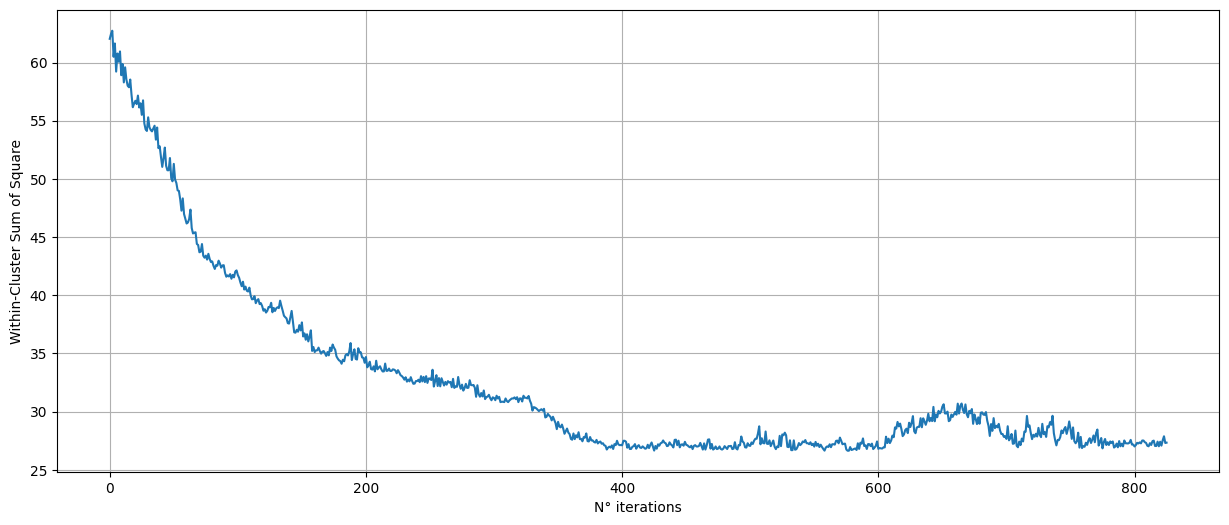

In [77]:
model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = 1000,
                                     learning_rate = 1,
                                     min_len=50,
                                     mode = 'single')

model.fit()
prediction = model.get_prediction()

fig_learning = plt.figure(figsize = (15,6))
plt.plot(model.error_history)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

array([ 55, 116, 295, 345], dtype=int32)

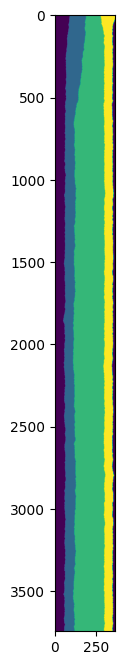

In [76]:
fig = plt.figure(figsize=(2,8))
plt.imshow(model.prediction_history.squeeze())

model.breakpoints